The purpose of this notebook is to verify that donors indeed do not overlap between training and test set, to create the proportions.pickle file which will be of use in the '4. Analysis per cell type' part and also to check (visually via the plots) how cell type proportions change as we vary the proportion of female cells in the dataset.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import vstack

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Import data, extract parameters:

In [7]:
path = "C:/Users/NORA/hlca_core.h5ad"
adata = anndata.read_h5ad(path, backed = 'r')

In [8]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']
cell_type_labels = adata.obs.ann_level_2
classes = sorted(list(set(cell_type_labels)))

In [9]:
with open('helper_pickle_files/color_mappings.pickle', 'rb') as file:
    color_mappings = pickle.load(file)

#### Functions for plotting

In [10]:
def plot_distribution(label_lists, sex_label_lists, title, colors, save = False):
    '''
    Use this for training set distribution.
    '''
    num_props = len(label_lists)
    class_labels = sorted(set(label for labels in label_lists for label in labels))
    num_classes = len(class_labels)

    class_counts = [{label: [0, 0] for label in class_labels} for _ in range(num_props)]

    props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    label_dict = {f"prop_{props[i]}": {} for i in range(num_props)}

    # calculate class counts for each proportion
    for i, (labels, sex_labels) in enumerate(zip(label_lists, sex_label_lists)):
        for label in class_labels:
            male_count = sum((labels == label) & (sex_labels == 'male'))
            female_count = sum((labels == label) & (sex_labels == 'female'))
            class_counts[i][label] = [male_count, female_count]

            # populate label_dict with counts for each proportion
            label_dict[f"prop_{props[i]}"][label] = (male_count, female_count)

    # plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(num_props)
    
    for i, label in enumerate(class_labels):
        total_counts = [sum(class_counts[j][label]) for j in range(num_props)]
        ax.bar(np.arange(num_props), total_counts, bottom=bottom, label=label, color=colors[i])
        bottom += total_counts
        
    ax.set_xticks(np.arange(num_props))
    ax.set_xticklabels([f"{float('{:.2f}'.format(prop))}" for prop in np.arange(0, 1.1, 0.1)])
    ax.set_xlabel('Proportion of Female Cells')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 30:
        ncol = 2
    else:
        ncol = 1
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/training_{title[-1]}.png")
    plt.show()

    # return values
    return label_dict
    
def plot_grouped_distribution(male_label_list, female_label_list, title, colors, legend = False, save = False):
    '''
    Use this for test set distribution.
    '''
    class_labels = sorted(list(set(male_label_list)))
    num_classes = len(class_labels)

    class_counts = {label: [0, 0] for label in class_labels}

    for label in class_labels:
        male_count = sum((male_label_list == label))
        female_count = sum((female_label_list == label))
        class_counts[label] = [male_count, female_count]

    # Plotting
    fig, ax = plt.subplots(figsize=(4, 6))
    bottom = np.zeros(2)
    
    for i, label in enumerate(class_labels):
        ax.bar([0,1], class_counts[label], bottom=bottom, label=label, color=colors[i])
        bottom += class_counts[label]

    ax.set_xticks([0,1])
    ax.set_xticklabels(['Male', 'Female'])
    ax.set_xlabel('Sex')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 15:
        ncol = 2
    else:
        ncol = 1

    if legend:
        ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/test_{title[-1]}.png")
    plt.show()

    return class_counts

#### Train function

In [11]:
from sklearn.model_selection import GroupShuffleSplit

In [12]:
def modif_train_clf_and_predict(X, y, sex_labels, individual_labels, proportion_female, classifier='knn', k=30):
    '''
    Modified train function that does not train or predict, only splits the data.
    '''

    np.random.seed(42)
    
    
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    individual_labels_male = np.array(individual_labels)[male_indices]

    X_female = X[female_indices]
    y_female = y[female_indices]
    individual_labels_female = np.array(individual_labels)[female_indices]
    
    # GroupShuffleSplit to ensure no overlap of individuals
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Split female data
    for train_idx, test_idx in gss.split(X_female, y_female, groups=individual_labels_female):
        X_female_train, X_female_test = X_female[train_idx], X_female[test_idx]
        y_female_train, y_female_test = y_female[train_idx], y_female[test_idx]
        individual_labels_female_train = individual_labels_female[train_idx]
        individual_labels_female_test = individual_labels_female[test_idx]

    # Split male data with same test size ratio
    for train_idx, test_idx in gss.split(X_male, y_male, groups=individual_labels_male):
        X_male_train, X_male_test = X_male[train_idx], X_male[test_idx]
        y_male_train, y_male_test = y_male[train_idx], y_male[test_idx]
        individual_labels_male_train = individual_labels_male[train_idx]
        individual_labels_male_test = individual_labels_male[test_idx]

    # ensure equal sized test sets
    # first, shuffle:
    male_shuffle_indices = np.random.permutation(X_male_test.shape[0])
    X_male_test = X_male_test[male_shuffle_indices]
    y_male_test = y_male_test[male_shuffle_indices]
    female_shuffle_indices = np.random.permutation(X_female_test.shape[0])
    X_female_test = X_female_test[female_shuffle_indices]
    y_female_test = y_female_test[female_shuffle_indices]

    # then extract equal number of entries for both sexes:
    min_test_size = min(X_male_test.shape[0], X_female_test.shape[0])
    X_male_test = X_male_test[:min_test_size]
    y_male_test = y_male_test[:min_test_size]
    X_female_test = X_female_test[:min_test_size]
    y_female_test = y_female_test[:min_test_size]

    
    # merge training sets back together
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]
    ind_train = np.concatenate([individual_labels_male_train, individual_labels_female_train])

    # Select female cells based on proportion_female
    selected_indices = fixed_select_indices_by_proportion(sex_labels_train, proportion_female)
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    ind_selected = ind_train[selected_indices]

    train_sex = np.array(sex_labels_train)[selected_indices]
    overlap = set(ind_selected) & set(np.concatenate([individual_labels_male_test, individual_labels_female_test]))
    return X_selected, y_selected, train_sex, overlap, y_female_test, y_male_test

    
def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed(42)
    sex_labels_series = pd.Series((el for el in sex_labels))
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
    # total will always be fixed_size
    # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])


#### Check proportions

ann_level_2 0
Donor overlap: 0
ann_level_2 0.1
Donor overlap: 0
ann_level_2 0.2
Donor overlap: 0
ann_level_2 0.3
Donor overlap: 0
ann_level_2 0.4
Donor overlap: 0
ann_level_2 0.5
Donor overlap: 0
ann_level_2 0.6
Donor overlap: 0
ann_level_2 0.7
Donor overlap: 0
ann_level_2 0.8
Donor overlap: 0
ann_level_2 0.9
Donor overlap: 0
ann_level_2 1
Donor overlap: 0


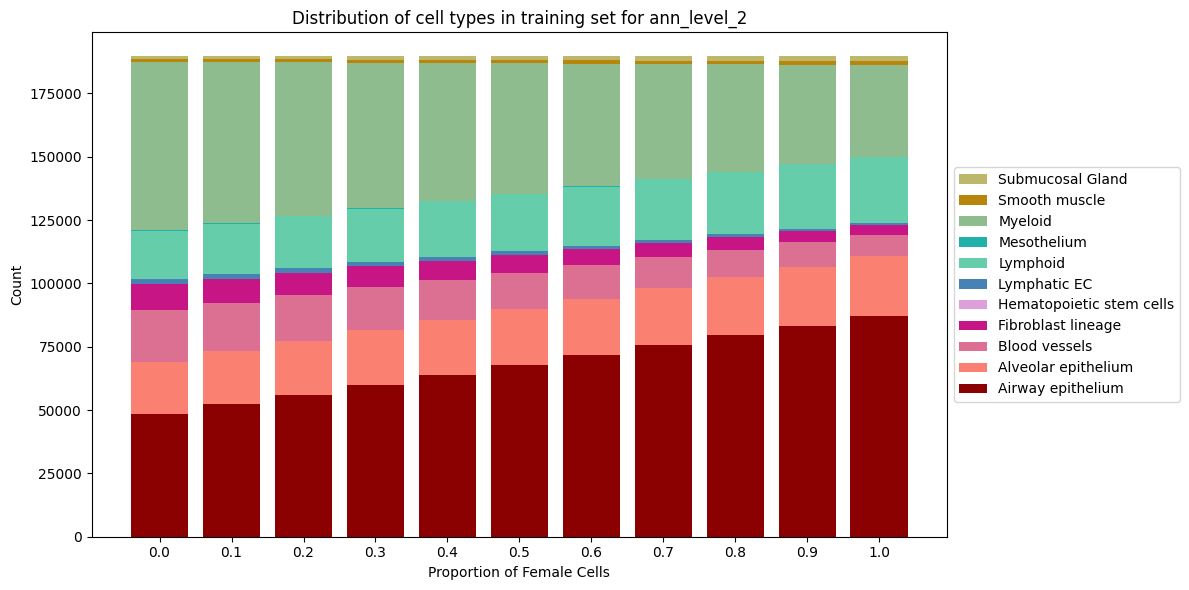

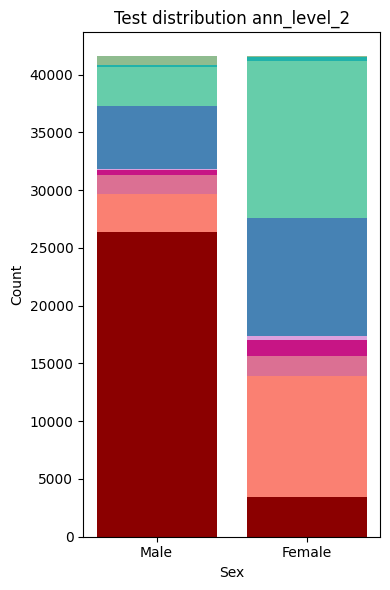

ann_level_3 0
Donor overlap: 0
ann_level_3 0.1
Donor overlap: 0
ann_level_3 0.2
Donor overlap: 0
ann_level_3 0.3
Donor overlap: 0
ann_level_3 0.4
Donor overlap: 0
ann_level_3 0.5
Donor overlap: 0
ann_level_3 0.6
Donor overlap: 0
ann_level_3 0.7
Donor overlap: 0
ann_level_3 0.8
Donor overlap: 0
ann_level_3 0.9
Donor overlap: 0
ann_level_3 1
Donor overlap: 0


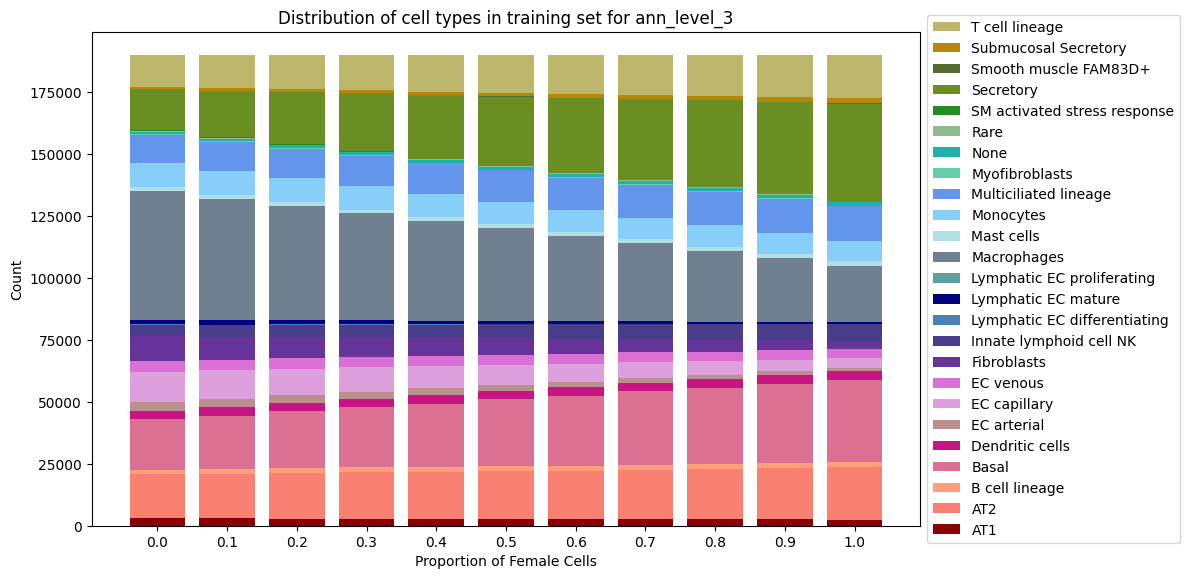

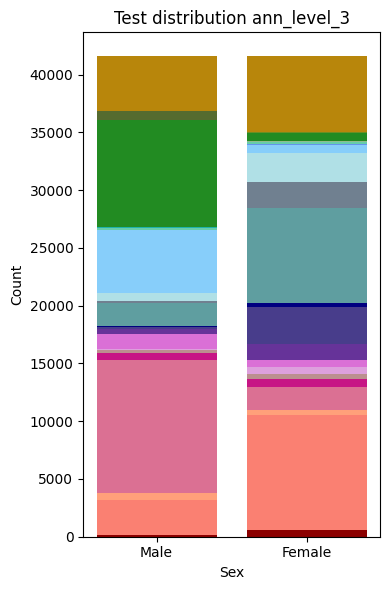

ann_level_4 0
Donor overlap: 0
ann_level_4 0.1
Donor overlap: 0
ann_level_4 0.2
Donor overlap: 0
ann_level_4 0.3
Donor overlap: 0
ann_level_4 0.4
Donor overlap: 0
ann_level_4 0.5
Donor overlap: 0
ann_level_4 0.6
Donor overlap: 0
ann_level_4 0.7
Donor overlap: 0
ann_level_4 0.8
Donor overlap: 0
ann_level_4 0.9
Donor overlap: 0
ann_level_4 1
Donor overlap: 0


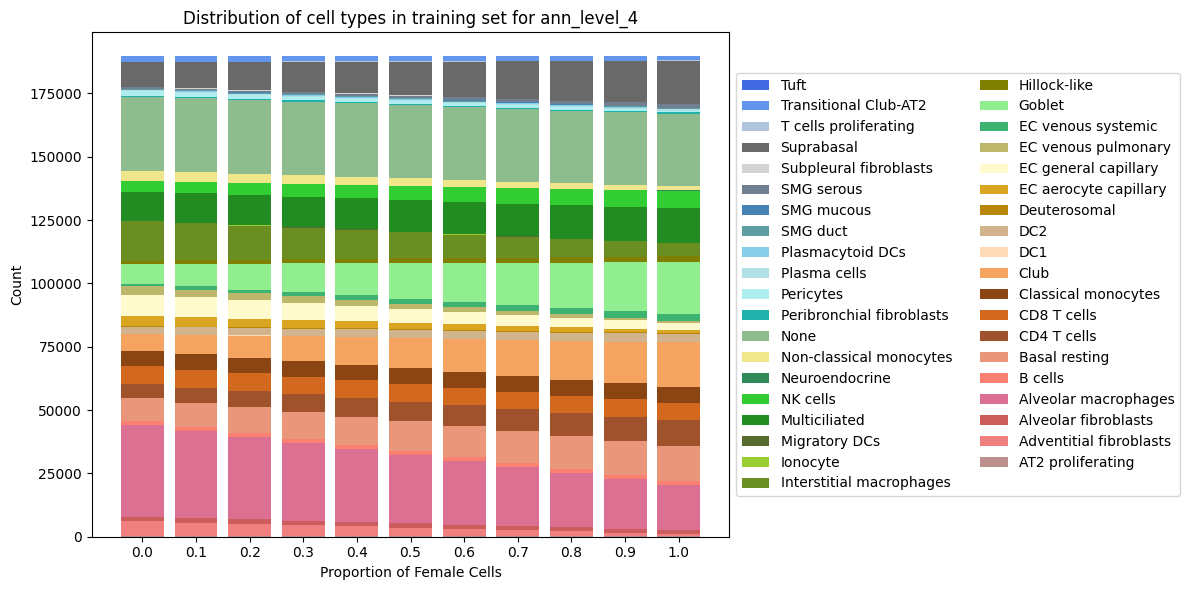

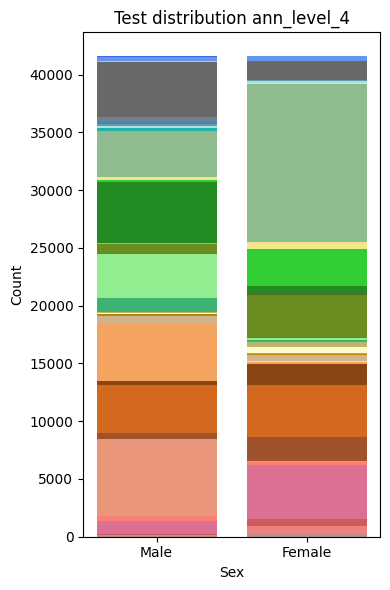

ann_finest_level 0
Donor overlap: 0
ann_finest_level 0.1
Donor overlap: 0
ann_finest_level 0.2
Donor overlap: 0
ann_finest_level 0.3
Donor overlap: 0
ann_finest_level 0.4
Donor overlap: 0
ann_finest_level 0.5
Donor overlap: 0
ann_finest_level 0.6
Donor overlap: 0
ann_finest_level 0.7
Donor overlap: 0
ann_finest_level 0.8
Donor overlap: 0
ann_finest_level 0.9
Donor overlap: 0
ann_finest_level 1
Donor overlap: 0


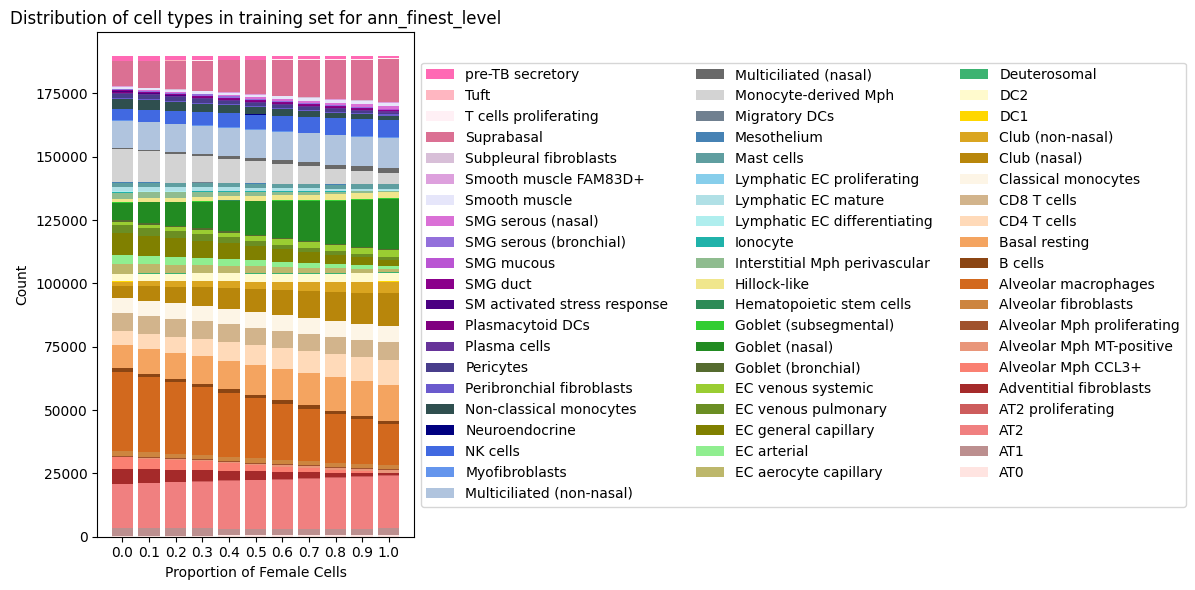

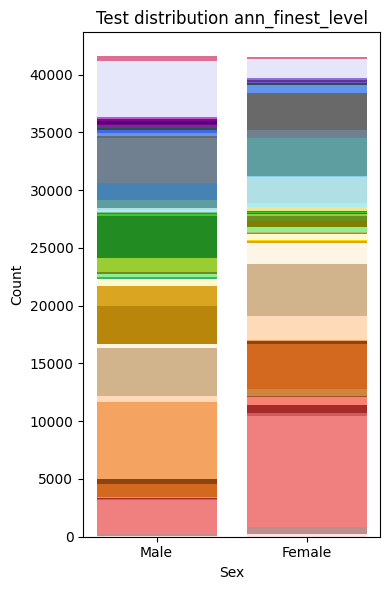

In [14]:
d_array = [] # to store training set counts
t_array = [] # to store test set counts

for i in ['ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_finest_level']:
    embedding = adata.obsm['X_scanvi_emb']
    sex_labels = adata.obs['sex']
    individual_labels = adata.obs['donor_id']
    cell_type_labels = adata.obs[i].astype(str)
    classes = sorted(set(cell_type_labels), reverse = True)
    label_lists = []
    sex_label_lists = []
    maletest_lists = []
    femaletest_lists = []

    for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        print(i, prop)
        X_selected, y_selected, train_sex, overlap, y_female_test, y_male_test = modif_train_clf_and_predict(embedding, cell_type_labels, sex_labels, individual_labels, prop)
        label_lists.append(y_selected)
        sex_label_lists.append(train_sex)
        maletest_lists.append(y_male_test)
        femaletest_lists.append(y_female_test)
        print(f'Donor overlap: {len(overlap)}')

    if i == 'ann_finest_level':
        d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings["ann_finest"].values()))
        t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings["ann_finest"].values()))
    else:
        d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings[f"ann_{i[-1]}"].values()))
        t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings[f"ann_{i[-1]}"].values()))

    # save counts
    d_array.append(d)
    t_array.append(t)

#### Export results

In [15]:
def extract_sexes(test_dict):
    return dict([(key, item[0]) for key, item in test_dict.items()]), dict([(key, item[1]) for key, item in test_dict.items()])

In [16]:
proportions = dict()
proportions["training_sets"] = {"ann_2": d_array[0], "ann_3": d_array[1], "ann_4": d_array[2], "ann_finest": d_array[3]}
proportions["male_test_sets"] = {"ann_2": extract_sexes(t_array[0])[0], "ann_3": extract_sexes(t_array[1])[0], "ann_4": extract_sexes(t_array[2])[0], "ann_finest": extract_sexes(t_array[3])[0]}
proportions["female_test_sets"] = {"ann_2": extract_sexes(t_array[0])[1], "ann_3": extract_sexes(t_array[1])[1], "ann_4": extract_sexes(t_array[2])[1], "ann_finest": extract_sexes(t_array[3])[1]}

with open(f'helper_pickle_files/donorbased_proportion_dictionary.pickle', 'wb') as file:
    pickle.dump(proportions, file)